# Implementación de CNN

In [2]:
# Cargar librerias y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion 

from sklearn.metrics import accuracy_score, balanced_accuracy_score   # para manejar metricas de desempeño 
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion

import sqlite3
import cv2

## Creación del DataFrame

### Preprocesamiento de imagen

In [2]:
def preprocess(img):
    p_img = cv2.resize(img, (64, 60))
    p_img = cv2.cvtColor(p_img, cv2.COLOR_BGR2GRAY)
    p_img  = p_img/255.
    return p_img 

### Carga de data

In [17]:
import os
# Creación de df
conn = sqlite3.connect('../training_data/datos_finales.sqlite', timeout=20)
cur = conn.cursor()
cur.execute('SELECT id, path FROM Videos')
ids = cur.fetchall()
data = {'image': [], 'vel': [], 'dir': []}
contador = 0
v_start = list()
abs_path = os.getcwd()
for id, path in ids:
    n_path = os.path.join(abs_path,path)
    print(f'Inicio de video {n_path}: {contador}')
    v_start.append(contador)
    cur.execute('SELECT vel, dir FROM Datos WHERE video_id = ?', (id, ))
    rawData = cur.fetchall()

    rawImgData = cv2.VideoCapture(n_path)

    for vel,dir in rawData:
        ret, frame = rawImgData.read()
        if not ret:
            break
        if vel <= 0:
            continue
        frame = preprocess(frame)
        data['image'].append(frame)
        data['vel'].append(vel)
        data['dir'].append(dir)
        contador += 1
imagenes = np.array(data['image'])
v_start.reverse()
df = pd.DataFrame(data=data)
df = df.drop(['image'], axis=1)

Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/prueba1_1.avi: 0
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/prueba1_2.avi: 490
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/vuelta_f.avi: 1133
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/vuelta_izqJ1.avi: 1553
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/derecha_J1.avi: 2236
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/derecha_Carrito1.avi: 2824
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/izquierda_Carrito2.avi: 3381
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/izquierda_Carrito3.avi: 4266
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/izquierda_Carrito4.avi: 6106
Inicio de video c:\Users\Usuario\Desktop\Proyecto\training_data/videos/izquierda_Carrito5.avi: 7683
Inicio de video c:\Users\Usuario\Desktop\Proyect

## Selección y acondicionamiento de datos 

In [17]:
def eliminarData(rango):
    global df, imagenes
    df = df.drop(rango)
    df.reset_index(drop=True, inplace=True)
    imagenes= np.delete(imagenes,rango,axis=0)
    print(imagenes.shape)

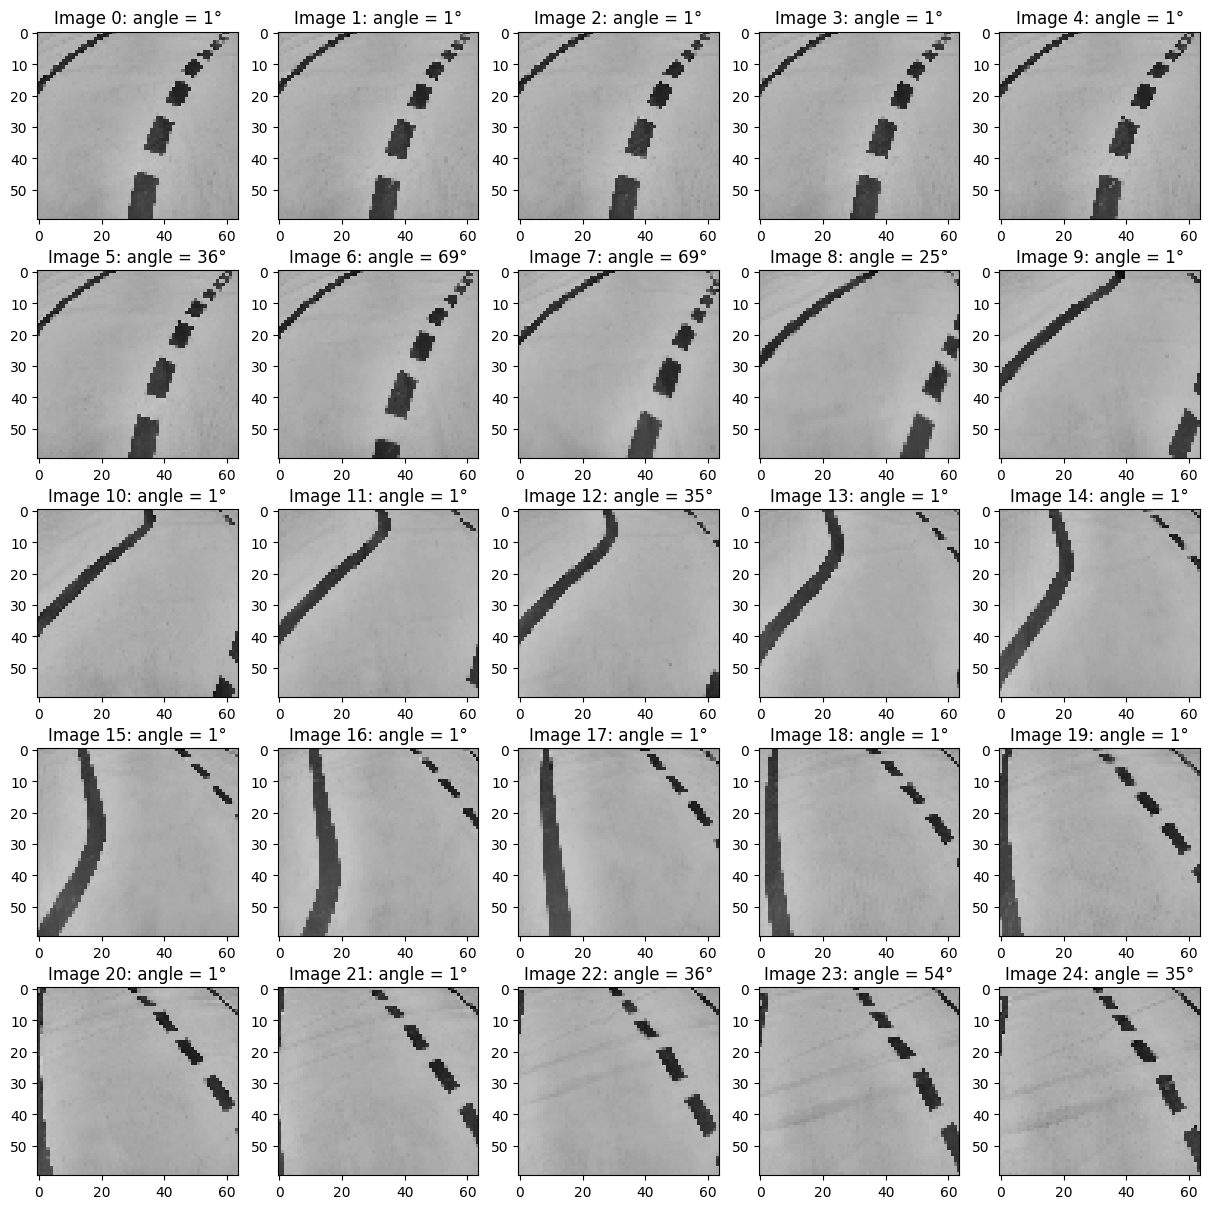

(4011, 2)


In [33]:
v_i = 3
start = v_start[v_i]
rows, cols = (5, 5)

fig = plt.figure(figsize=(3*cols, 3*rows))
plots = fig.subplots(rows, cols)

for i, axes in enumerate(plots, 0):
    for j, ax in enumerate(axes,0):
        index = start + i*cols + j
        ax.imshow(imagenes[index,:,:], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Image {index}: angle = {df['dir'][index]}°")

plt.show()
print(df.shape)

In [32]:
# Elimina datos inválidos
rango = range(v_start[v_i],v_start[v_i]+25)
eliminarData(rango)

(4011, 60, 64)


In [10]:
# Angle classification
def clasificador(ang):
    if ang <= 20:
        return 0
    elif ang <= 30:
        return 1
    elif ang <= 40:
        return 2
    elif ang <= 50:
        return 3
    else:
        return 4

In [18]:
df['encoded_angles'] = df['dir'].apply(clasificador)

In [21]:
print(df.shape)
print(imagenes.shape)
df.to_csv('../training_data/processed_data/data.csv', index=False)
np.save("../training_data/processed_data/img.npy", imagenes)

(15784, 3)
(15784, 60, 64)


## Training

### Carga de datos para el entrenamiento

In [53]:
with open('../training_data/processed_data/img.npy', 'rb') as f:
    imagenes = np.load(f)
df = pd.read_csv('../training_data/processed_data/data.csv')
print(f'Imagenes: {imagenes.shape}\nDatos:')
df.head

Imagenes: (15784, 60, 64)
Datos:


<bound method NDFrame.head of         vel  dir  encoded_angles
0      4.59   40               2
1      4.95   40               2
2      4.77   30               1
3      4.74   30               1
4      4.71   30               1
...     ...  ...             ...
15779  4.74   40               2
15780  4.68   40               2
15781  4.68   50               3
15782  4.68   50               3
15783  4.59   50               3

[15784 rows x 3 columns]>

### Visualización de la distribución de datos de entrenamiento

In [54]:
plt.hist(df['encoded_angles'])

(array([4257.,    0., 1825.,    0.,    0., 3575.,    0., 4046.,    0.,
        2081.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

### Separación de train-test

In [56]:
import tensorflow as tf
# Carga librerias de Keras para redes neuronales
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import model_from_json
from keras.utils import np_utils

In [57]:
angles = keras.utils.to_categorical(np.asarray(df['encoded_angles']))
images_training, images_testing, angles_training, angles_testing = train_test_split(imagenes, angles, test_size=0.3)
# Número de clases a clasificar:
bins = angles_training.shape[1]


In [58]:
images_training.shape

(11048, 60, 64)

### Definición de arquitecturas

In [197]:
def define_modelo_MLP(bins):
    modelo = Sequential(name='Arq3v3_Dp-cnn')  # Sequential indica que el modelo sera una pila de capas conec tadas secuencialmente (CNN) 
    modelo.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (60, 64, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add( Flatten() ) 
    modelo.add( Dense(128, activation="relu") ) 
    modelo.add( Dense(16, activation="relu") ) 
    modelo.add( Dropout(.2) )
    modelo.add( Dense(bins, activation="softmax") )
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
    return modelo

In [198]:
# Funcion para definir el modelo MLP de la figura de arriba
def define_modelo_MLP2(bins):
    modelo = Sequential(name='Arq4_cnn')  # Sequential indica que el modelo sera una pila de capas conec tadas secuencialmente (CNN) 
    modelo.add(Conv2D(64, (5, 5), activation='relu', padding='same', input_shape = (60, 64, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add( Flatten() ) 
    modelo.add( Dense(64, activation="relu") ) 
    modelo.add( Dense(bins, activation="softmax") )
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
    return modelo

In [59]:
def define_modelo_MLP3(bins):
    modelo = Sequential(name='Arq5')  # Sequential indica que el modelo sera una pila de capas conec tadas secuencialmente (CNN) 
    modelo.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (60, 64, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add( Flatten() ) 
    modelo.add( Dense(64, activation="relu") ) 
    modelo.add( Dropout(.2) )
    modelo.add( Dense(bins, activation="softmax") )
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )
    return modelo

In [200]:
# Funcion para definir el modelo MLP de la figura de arriba
def define_modelo_MLP2_222(bins):
    modelo = Sequential(name='Arq3v3_mpf-cnn')  # Sequential indica que el modelo sera una pila de capas conec tadas secuencialmente (CNN) 
    modelo.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape = (60, 64, 1)))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    modelo.add(MaxPooling2D((2, 2)))
    modelo.add( Flatten() ) 
    modelo.add( Dense(64, activation="relu") ) 
    modelo.add( Dropout(.2) )
    modelo.add( Dense(bins, activation="softmax") )
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'] )    
    return modelo

Lista de modelos definidos:

In [60]:
modelos = [define_modelo_MLP3]

### Entrenamiento

In [61]:
# plotea curvas de aprendizaje
def plot_learning_curve(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.show()

In [62]:
# evalua una arquitectura de modelo neuronal en k-fold cross-validation. Se pasa la funcion constructora del modelo
def evalua_modeloCV(model_buider, X, y, n_folds=5):
    accuracies, histories = list(), list()
    # prepara folds
    seed = 7   
    kfold = KFold(n_splits=n_folds, random_state=seed, shuffle= True) 
    
    # realiza la cross-validacion
    for train_ix, test_ix in kfold.split(X):   # por cada fold de test
        # define modelo MLP
        modelo = model_buider()
        # selecciona los sets de training y de test 
        trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
        # entrena el modelo
        history = modelo.fit(trainX, trainY, epochs=12, batch_size=32, validation_data=(testX, testY), verbose=0)
        # obtiene metricas de evaluacion en el fold de test del modelo entrenado 
        _, acc = modelo.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
         
        accuracies.append(acc)   # guarda la acuracia obtenida en el fold  de test
        histories.append(history)  # guarda hitórico de evolucion de scores entrenamiento  (loss y acuracias)
    return accuracies, histories

In [63]:
cv_data = dict()
cv_data['name'] = []
cv_data['acc'] = []
cv_data['sum'] = []
for modelo in modelos:
    md = modelo(bins)
    cv_data['name'].append(md.name)
    file = f'../training_data/model_summaries/{md.name}.txt'
    with open(file, 'w') as f:
        md.summary(print_fn=lambda x: f.write(x + '\n'))
    cv_data['sum'].append(file)
    print(md.name)
    # Entrenamiento
    cv_accuracies, cv_histories = evalua_modeloCV(lambda: modelo(bins), images_training, angles_training, 3)
    cv_data['acc'].append(cv_accuracies)
    print('-'*50)

Arq5
> 67.798
> 68.966
> 67.653
--------------------------------------------------


Guardando modelos entrenados

In [65]:
df1 = pd.read_csv('../training_data/training_sessions.csv')
df_sav = pd.DataFrame(data=cv_data)
df1 = pd.concat([df1, df_sav.loc[:]]).reset_index(drop=True)
df1.to_csv('../training_data/training_sessions.csv', index=False)

### Evaluación de modelos

In [72]:
stats = pd.read_csv('../training_data/training_sessions.csv')
stats['acc']=stats['acc'].apply(lambda s: [float(x.strip(' []')) for x in s.split(',')])
stats['acc_mean']=stats['acc'].apply(lambda s: np.mean(s))
stats = stats.sort_values(by=['acc_mean'], ascending=False).reset_index().head(4)
stats.head(3)

,index,name,acc,sum,acc_mean
0,11,4-conv-1-fc,"[0.6779798865318298, 0.6896551847457886, 0.676...",../training_data/model_summaries/Arq5.txt,0.681390
1,7,3-conv-2-fc,"[0.6481723189353943, 0.6325065493583679, 0.657...",model_summaries/Arq1_3v2_dp-cnn-drp.txt,0.645959
2,10,4-conv-3-fc,"[0.6432767510414124, 0.6602480411529541, 0.632...",model_summaries/Arq3v3_Dp-cnn-up-fc.txt,0.645304


In [75]:
df = dict()
df['Arquitectures'] = list()
df['Accuracy'] = list()
for name,accs in zip(stats['name'], stats['acc']):
    for acc in accs:
        df['Arquitectures'].append(name)
        df['Accuracy'].append(acc)
df=pd.DataFrame(df)

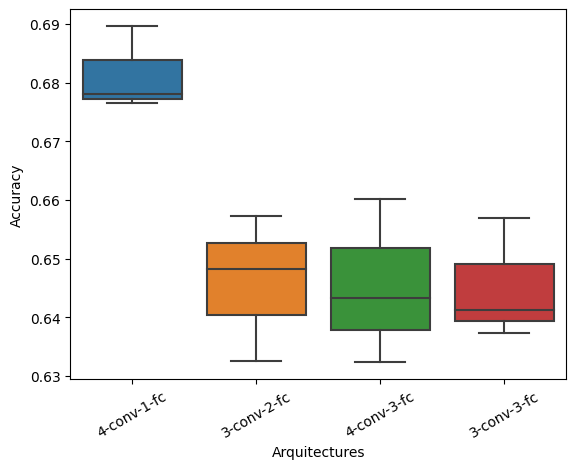

In [76]:
import seaborn as sns
ax = sns.boxplot(x='Arquitectures', y='Accuracy', data=df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

# Modelo final

In [32]:
# define modelo final
modelo_finalMLP = define_modelo_MLP3(bins)

# entrena  modelo final
modelo_finalMLP.fit(images_training, angles_training, epochs=30, batch_size=32, verbose=0)  # verbose=0  es para no mostrar informacion de entrenamiento

# evalua modelo final en  dataset de validacion
_, acc = modelo_finalMLP.evaluate(images_testing, angles_testing, verbose=0)
print('Accuracy > %.3f' % (acc * 100.0))


Accuracy > 70.017


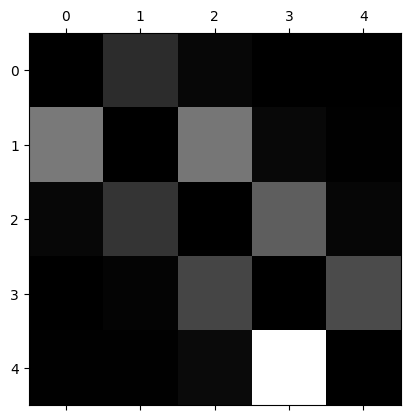

In [35]:
# obtiene las categorias de las muestras de validacion (lo contrario de one hot)
true_labels = np.argmax(angles_testing, axis=1)
predictions_test_MLP = modelo_finalMLP.predict(images_testing, verbose=0 ) 
predicted_labels_MLP = np.argmax(predictions_test_MLP, axis=1)

# obtiene matriz de confusion
conf_mx = confusion_matrix(true_labels, predicted_labels_MLP)

# normaliza las filas de la matriz de confusion
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# coloca 0 en la diagonal para enfocarnos en los errores 
np.fill_diagonal(norm_conf_mx, 0)

# plotea 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [36]:
conf_mx

array([[1121,  111,   19,    1,    2],
       [ 138,  302,  133,   10,    2],
       [  15,  108,  727,  191,   13],
       [   2,   11,  163,  866,  178],
       [   2,    2,   12,  307,  300]], dtype=int64)

## Guardar modelo

In [37]:
# salva los pesos en archivo h5
modelo_finalMLP.save("../models/modelo_final_data_comp.h5")
print("Modelo salvado en disco")

Modelo salvado en disco


## Cargar modelo

In [22]:
from keras.models import load_model
modelo_cargado = load_model('../models/modelo_test1.h5')
# output = modelo_cargado.predict(img_processed)
# print(output)

In [23]:
modelo_cargado.summary()

Model: "Arq3v3_Dp-cnn-dw-fc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_323 (Conv2D)         (None, 60, 64, 64)        640       
                                                                 
 max_pooling2d_261 (MaxPooli  (None, 30, 32, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_324 (Conv2D)         (None, 30, 32, 128)       73856     
                                                                 
 max_pooling2d_262 (MaxPooli  (None, 15, 16, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_325 (Conv2D)         (None, 15, 16, 256)       295168    
                                                                 
 max_pooling2d_263 (MaxPooli  (None, 7, 8, 256)

## Prueba de imagen

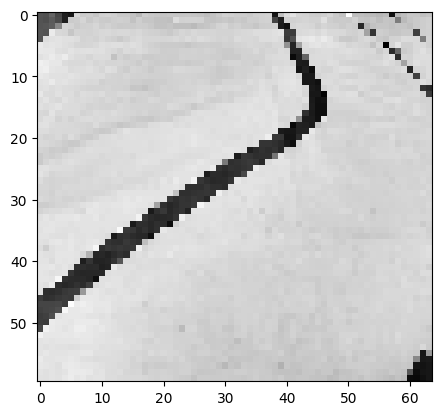

In [160]:
img = imagenes[1000,:,:]
plt.imshow(img, cmap='gray')

In [99]:
img.shape

(60, 64)

In [161]:
img = img.reshape(1, 60, 64, 1)
output = modelo_cargado.predict(img)
print(output)

1/1 [==============================] - 0s 93ms/step
[[7.9790580e-01 6.7933686e-03 1.8057716e-01 1.4513902e-02 2.0979637e-04]]
